In [ ]:
import random
random.seed(42)
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import numpy as np
import pytorch_lightning as pl
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable as V
import torchtext
from torchtext import data

## Neural Language Models(NLMs)

Neural Language models are continuous probability models which approaches the same problem that statistical models tackled from a different perpective. And this approach has consistently beaten the benchmarks set by statistical models, both in the LM itself, as well as the downstream tasks. 

>A fundamental problem that makes statistical language modelling difficult is the curse of dimensionality. If one wants to model the joint distribution of 10 consecutive words in a natural language with a vocabulary of V of size 100000, there are potentially $100000^{10} - 1 = 10^{50}-1$ free parameters.

>When modeling continuous variables, we obtain generalization more easily (e.g. with smooth classes of functions like multi-layer neural networks or Gaussian mixture models) because the function to be learned can be expected to have some local smoothness properties.  - [Bengio et.al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

All the Smoothing and Backoff techniques we have seen earlier is to overcome this shortcoming with a few crutches. Bengio et.al. continues to propose two key points of improvements over the Statistical LMs:
- Trigram or Fourgram models were the SOTA at that point. But even there, we resort to all kinds of techniques like Kneser-Ney or Witten-Bell Smoothing to leverage the information from preceeding words from the context.
- Statistical LMs also do not consider semantic similarity between two words. _"A cat is walking in a bedroom"_ is different from _"A dog is walking in a room"_ because the LM doesn't know that cat and dog are similar, or room and bedroom are similar.


The neural network approach to language modeling can be described using the three following model properties:

>- Associate each word in the vocabulary with a distributed word feature vector.
>- Express the joint probability function of word sequences in terms of the feature vectors of these words in the sequence.
>- Learn simultaneously the word feature vector and the parameters of the probability function. 

> [Bengio et.al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

Let's pick the same dataset we were working with and train some Neural models. I have preprocessed the QuotesDB, split into Train, Val and Test, and saved into txt file. And learning from the previous models, have slightly refined the cleaning process where we now replace contractions with full versions and insert spaces between punctuations and words. _(Accompanying code can be found in Appendix-quotes_to_txt.ipynb)_

We will be sticking with PyTorch and the transformers library from huggingface for thr remainder of exercise. And for making things easier, we are going to be using PyTorch Lightning, which is an abstraction over pure PyTorch, hiding away the boilerplate code we have to write for training a model. And it also takes up the tedious job of making the training work on GPUs, multi-GPUs etc. seamlessly. the only ting it asks in return is that you structure your code in a specific way. And that specific way is pretty much the way we usually write code.

## Pytorch Lightning
PyTorch Lightning is an attempt at standardizing PyTorch code, abstract away boilerplate code other slightly technical training aspects like distributed training, mixed precision training, multi-GPU training, etc so that researchers can focus on what they do best and accelerate the research cycle. It also acts as a standard for production systems which makes the code less prone to errors and structured.

Below is a diagram from a [medium post](https://towardsdatascience.com/supercharge-your-ai-research-with-pytorch-lightning-337948a99eec) by the author of the library. It shows what parts of the whole cycle have been automated by Pytorch Lightning.

![](images/lightning.jpeg)

The boxes in Blue are the boxes we need to fill in with our code, and the rest of them are taken care by the framework. If you have written PyTorch code before, porting to PyTorch Lightning is really easy. I strongly advise you to check out [this link](https://towardsdatascience.com/from-pytorch-to-pytorch-lightning-a-gentle-introduction-b371b7caaf09) to get an overview of what it can do.

There is one mandatory requirement and an optional and recommended requirement from Pytorch Lightning:
1. (Mandatory) We should be defining our model inheriting LightningModule and not nn.Module. And in this class, we add the training, validation and test steps overriding predefined methods.
2. (Optional) We should organize all our data processing and loading to a class inheriting DataModule. This has everything related to data(downloading, loading, splitting, tokenization, batching, etc.).

So, let's define our DataModule first.

### DataModule

> A datamodule encapsulates the five steps involved in data processing
> in PyTorch:
> 
> Download / tokenize / process.
> 
> Clean and (maybe) save to disk.
> 
> Load inside Dataset.
> 
> Apply transforms (rotate, tokenize, etc…).
> 
> Wrap inside a DataLoader. 

> To define a DataModule define 5 methods:
> 
> -   prepare_data (how to download(), tokenize, etc…)
>     
> -   setup (how to split, etc…)
>     
> -   train_dataloader
>     
> -   val_dataloader(s)
>     
> -   test_dataloader(s)

_- PyTorch Lightning Docs_

_**N.B.**_ - To use DataModules, you should _**pip install pytorch-lightning==0.9.0rc2**_

A simplified DataModule is below, but we are going to use the fullblown one after importing. Some of it like the BPTTIterator, you might not get it now. But I'll explain it when we talk about LSTMs. 

```python
class QuotesDataModule(pl.LightningDataModule):

    def __init__(
        self,
        train_file: str,
        valid_file: str = None,
        test_file: str = None,
        tokenizer=None,
        pretrained_vectors=None,
        batch_size=32,
        bptt=6,
    ):

        super().__init__()
        self.train_file = train_file
        self.valid_file = valid_file
        self.test_file = valid_file
        self.tokenizer = spacy_tokenizer if tokenizer is None else tokenizer
        self.TEXT = data.Field(lower=True, tokenize=self.tokenizer)
        self.pretrained_vectors = pretrained_vectors
        self.batch_size = batch_size
        self.bptt = bptt
        self._load_data()
        self._build_vocab()
        self.vocab = self.TEXT.vocab

    def _load_data(self):
        # Read file and tokenize
        self.train_data = LanguageModelingDataset(self.train_file, self.TEXT)
        if self.valid_file:
            self.valid_data = LanguageModelingDataset(self.valid_file, self.TEXT)
        else:
            self.valid_data = None
        if self.test_file:
            self.test_data = LanguageModelingDataset(self.test_file, self.TEXT)
        else:
            self.test_data = None

    def _build_vocab(self):
        self.TEXT.build_vocab(self.train_data, vectors=self.pretrained_vectors)

    @classmethod
    def _make_iter(cls, dataset, batch_size, bptt_len):
        if dataset:
            _iter = data.BPTTIterator(
                dataset,
                batch_size=batch_size,
                bptt_len=bptt_len,  # this is where we specify the sequence length
                repeat=False,
                shuffle=True,
            )
        else:
            _iter = []
        return _iter

    def prepare_data(self):
        # No action here
        pass

    def setup(self, stage=None):
        # No action here
        pass

    def train_dataloader(self):
        return self._make_iter(self.train_data, self.batch_size, self.bptt)

    def val_dataloader(self):
        return self._make_iter(self.valid_data, self.batch_size, self.bptt)

    def test_dataloader(self):
        return self._make_iter(self.test_data, self.batch_size, self.bptt)
```

Now let's start the model building.

## LSTM

Although the Neural Language Models did not start with LSTMs, we will just skip ahead to the good part and look at an LSTM. Before that a quick refresher on LSTMs(rather RNNs). To understand the exact difference between vanilla RNNs and LSTMs, you can refer to this [amazing blog by Christopher Olah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

RNNs are Neural Network architectures specifically suited to sequences. They were designed to overcome the lack of memory in traditional Neural Networks. What you see below is a typical RNN , where you have a sequence, $x_1, x_2, ..., x_t$, where t is the number of timesteps. The core idea in an RNN is the use of a hidden state as kind of a memory to remember the elements of the sequence it has already seen.

So what an RNN will do is take in the inputs one by one, and spit out two outputs, a prediction and a hidden state. This hidden state and the next element in the timestep is passed to the network again, and it spits out another prediction and a new hidden state. This continues till you reach the end of the sequence.

![lstm](images/lstm.png)

Now let's see how this translates into the PyTorch implementation. The RNN implementation in PyTorch(`batch_first=False`) takes in a matrix of shape `(# of timesteps, batch size)` and returns an output of the same shape - `(# of timesteps, batch size)`. Intuitively, we may think that it need not return the intermediate outputs, but just the final output because that's the output after considering all the sequence, right? But there are many usecases, including LMs, where it will be beneficial to have access to intermediate outputs as well. The first approach might be fine for something like a Sentiment analysis, where you accumulate the information over an entire sentence and then make a classification, but if you think about use cases like NER tagging, Text Generation, etc. we would use all or multiple outputs.

![lstm](images/lstm_pytorch.png)

Now let's think about how we formulate the data for training. Even though there are many ways of training a Language Model, let's choose the simplest one - Next Word Prediction. Just like we did with the Statistical Language Models, we give the model a sequence of words and ask it to predict the next word. Only here, we do it in mini-batches. And how do we do that? We can always write our own iterator which offsets the sequence by one and pose it as the target, but why reinvent the wheel. `torchtext` has a BPTTIterator which does just this job. You provide a sequence of words to the iterator and mention the batch size and the mazimum length of context(bptt), it does the dirty job of batching the sequence into text-target pairs.

If the sequence of words are, _the quick brown fox jumped over the lazy dog_, we can use the BPTTIterator to make following text - target pairs(bptt=3):


|Text|Target  |
|--|--|
| the | quick |
| quick | brown |
| brown | fox |

|Text|Target  |
|--|--|
| fox | jumped |
| jumped | over |
| over | the |

and so on.

Now let's get to model building

In [2]:
from pytorch_lightning_lm.data_module import QuotesDataModule
from pytorch_lightning_lm.model import RNNModel
from pytorch_lightning_lm.metrics import Perplexity
from pytorch_lightning.loggers import WandbLogger
from argparse import ArgumentParser

In [12]:
parser = ArgumentParser()
parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")

# add PROGRAM level args
parser.add_argument('--project-name', type=str, default='neural_lms')
parser.add_argument('--experiment-tag', type=str, default='RNN_LM')
parser.add_argument('--use-cuda', type=bool, default=True)
parser.add_argument('--use-wandb', type=bool, default=True)
parser.add_argument('--log-gradients', type=bool, default=False)

# add model specific args
# parser = LitModel.add_model_specific_args(parser)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--bptt', type=int, default=3)
parser.add_argument('--rnn-type', type=str, default="LSTM")
parser.add_argument('--nhid', type=int, default=32)
parser.add_argument('--nlayers', type=int, default=2)
parser.add_argument('--pretrained-vector', type=str, default="fasttext.simple.300d")

# add all the available trainer options to argparse
parser.add_argument('--max_epochs', type=int, default=3)
parser.add_argument('--fast_dev_run', type=bool, default=False)
# ie: now --gpus --num_nodes ... --fast_dev_run all work in the cli
# parser = Trainer.add_argparse_args(parser)

args = parser.parse_args()

In [4]:
device = torch.device('cuda') if (torch.cuda.is_available()&args.use_cuda) else torch.device('cpu')


In [5]:
experiment_name = f"{args.experiment_tag}_{args.rnn_type}_{args.batch_size}_{args.bptt}_{args.nhid}_{args.nlayers}"

In [7]:
dm = QuotesDataModule(
    train_file="data/quotesdb/funny_quotes.train.txt",
    valid_file="data/quotesdb/funny_quotes.val.txt",
    test_file="data/quotesdb/funny_quotes.test.txt",
    tokenizer=None,
    batch_size=args.batch_size,
    bptt=args.bptt,
    pretrained_vectors=args.pretrained_vector,
)

C:\Users\manujoseph\Anaconda3\envs\bot\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
C:\Users\manujoseph\Anaconda3\envs\bot\lib\site-packages\torchtext\data\example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


In [8]:
vocab = dm.vocab
weight_matrix = vocab.vectors
ntoken, ninp = weight_matrix.shape

In [9]:
pad_idx = vocab.stoi["<pad>"]

In [21]:
ppl = Perplexity(pad_idx)
model = RNNModel(
    rnn_type=args.rnn_type, ntoken=ntoken, ninp=ninp, nhid=args.nhid, nlayers=args.nlayers, batch_size=args.batch_size, device_type= device.type, pretrained_vectors=weight_matrix, metric=ppl
)

In [23]:
if args.use_wandb:
    wandb_logger = WandbLogger(name=experiment_name,project=args.project_name)
    if args.log_gradients:
        wandb_logger.watch(model, log='gradients', log_freq=100)
    logger= wandb_logger
else:
    logger= True
    
trainer = pl.Trainer(gpus=1 if device.type =='cuda' else 0, max_epochs=args.max_epochs, logger=logger)#, logger= wandb_logger) #fast_dev_run=True,

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


## Auto LR Finder

In [24]:
# Run learning rate finder
lr_finder = trainer.lr_find(model, train_dataloader=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())

C:\Users\manujoseph\Anaconda3\envs\bot\lib\site-packages\torchtext\data\iterator.py:48: UserWarning: BPTTIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
C:\Users\manujoseph\Anaconda3\envs\bot\lib\site-packages\pytorch_lightning\utilities\distributed.py:22: UserWarning: Warning, `module_arguments` dropped from checkpoint. An attribute is not picklable Can't pickle local object '_apply_to_outputs.<locals>.decorator_fn.<locals>.new_func'
  warnings.warn(*args, **kwargs)

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | metric    | Perplexity       | 0     
2 | drop      | Dropout          | 0     
3 | encoder   | Embeddi

C:\Users\manujoseph\Anaconda3\envs\bot\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


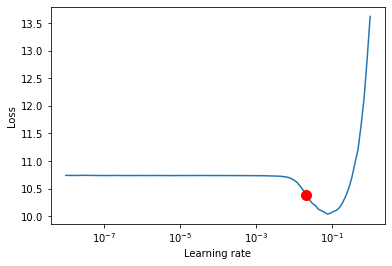

In [25]:
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

In [26]:
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
new_lr

0.02089296130854041

In [27]:
model.lr = new_lr

In [29]:
trainer.fit(model, datamodule=dm)


  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | metric    | Perplexity       | 0     
2 | drop      | Dropout          | 0     
3 | encoder   | Embedding        | 13 M  
4 | rnn       | LSTM             | 51 K  
5 | decoder   | Linear           | 1 M   


C:\Users\manujoseph\Anaconda3\envs\bot\lib\site-packages\pytorch_lightning\utilities\distributed.py:22: RuntimeWarning: The metric you returned None must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of loss in validation_epoch_end()?
  warnings.warn(*args, **kwargs)
C:\Users\manujoseph\Anaconda3\envs\bot\lib\site-packages\pytorch_lightning\utilities\distributed.py:22: RuntimeWarning: Can save best model only with loss available, skipping.
  warnings.warn(*args, **kwargs)
C:\Users\manujoseph\Anaconda3\envs\bot\lib\site-packages\pytorch_lightning\utilities\distributed.py:22: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [20]:
trainer.save_checkpoint(f"models/{experiment_name}.ckpt")

In [12]:
_model = RNNModel.load_from_checkpoint("models/example.ckpt")

In [21]:
trainer.test(model, datamodule=dm)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(10.6672, device='cuda:0'),
 'test_ppl': tensor(42923.6484, device='cuda:0')}
--------------------------------------------------------------------------------



[{'test_loss': 10.667179107666016, 'test_ppl': 42923.6484375}]

In [23]:
num_words = 20
seed = "When life hands you lemons"

In [25]:
model = model.to('cpu')
model.hidden = model.init_hidden(1)
model.eval()
sentence = []
seq = torch.ones(bptt, dtype=torch.long)
toks = dm.TEXT.preprocess(seed)
x = dm.TEXT.numericalize([toks]).to('cpu').squeeze(1)
length = min(len(x), bptt)
seq[-length:] = x[-length:]
seq = seq.unsqueeze(1)
for i in range(num_words):
    out = model(seq)
    gen_token = torch.argmax(out[-1,:])
    sentence.append(gen_token.item())
    gen_token = gen_token.unsqueeze(0).unsqueeze(0)
    seq = torch.cat([seq, gen_token])[1:]
    
    

In [26]:
" ".join([dm.TEXT.vocab.itos[word] for word in sentence])

'his his his his his his his his his his his his his his his his his his his his'